In [1]:
import matplotlib.pyplot as plt
import numpy as np

from frechet_fda.data_generation_tools import (
    gen_params_scenario_one,
    make_truncnorm_pdf,
)
from frechet_fda.distribution_tools import (
    frechet_mean,
    get_optimal_range,
    inverse_log_qd_transform,
    log_qd_transform,
    make_distribution_objects,
    mean_func,
)
from frechet_fda.fda_tools import (
    compute_centered_data,
    compute_cov_function,
    compute_principal_components,
    gen_qdtransformation_pcs,
    k_optimal,
    karhunen_loeve,
    mode_of_variation,
    total_frechet_variance,
)

In [2]:
# Set parameters
n = 200
grid_size = 10000
trunc = 3
mus, sigmas = gen_params_scenario_one(n)
# Sort sigmas, because when summing Distribution instances something goes wrong otherwise
sigmas.sort()

In [3]:
# Generate pdfs within truncation points
pdfs = make_truncnorm_pdf(-trunc, trunc, mus, sigmas, grid_size=grid_size)
# Make Distribution class objects
my_pdfs = make_distribution_objects(pdfs)
my_cdfs = [pdf.integrate() for pdf in my_pdfs]
my_qfs = [cdf.invert() for cdf in my_cdfs]
my_qdfs = [qf.differentiate() for qf in my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
new_ranges = get_optimal_range(my_pdfs)
# Generate pdfs again, this time within individual ranges
pdfs2 = [
    make_truncnorm_pdf(
        new_ranges[i][0],
        new_ranges[i][1],
        mus[i],
        sigmas[i],
        grid_size=grid_size,
    )[0]
    for i in range(n)
]

C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.00045380448286858055
 In position: 199
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\numerics_tools.py:37: RuntimeWarning: divide by zero encountered in divide
  d_y[:-1] = np.diff(y_vals) / np.diff(d_x)
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.0512038445709138e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.1517970267327371e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: Us

In [4]:
# Generate all the distribution objects
new_pdfs = make_distribution_objects(pdfs2)
new_cdfs = [pdf.integrate() for pdf in new_pdfs]
new_qfs = [cdf.invert() for cdf in new_cdfs]
new_qdfs = [qf.differentiate() for qf in new_qfs]

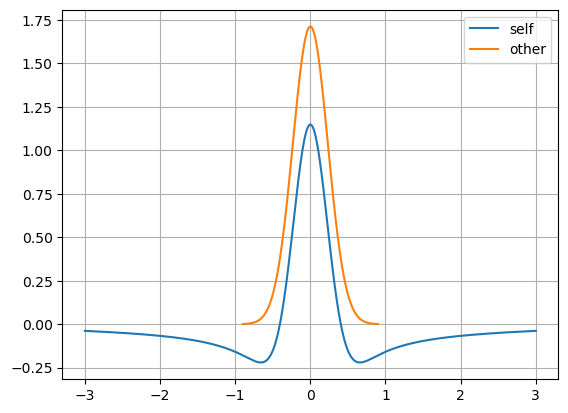

In [5]:
# Compute centered data, just to see whether it works
# One can clearly see how inappropriate it is to apply fda methods on densities
mean_pdf, centered_pdfs = compute_centered_data(new_pdfs)
centered_pdfs[sigmas.argmin()].compare(new_pdfs[sigmas.argmin()])

In [6]:
covariance_function = compute_cov_function(centered_pdfs)

In [7]:
eigenvalues, eigenfunctions = compute_principal_components(
    centered_pdfs[0].x,
    covariance_function,
)

## Transformation FPCA

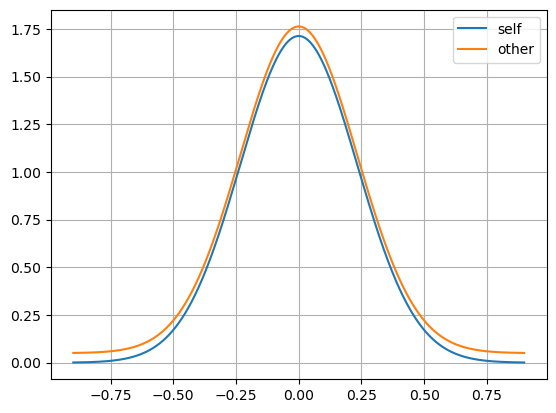

In [8]:
# Transform pdf sample, and test whether inverse works
log_qdfs = log_qd_transform(new_pdfs)
inverse_log_qdfs = inverse_log_qd_transform(log_qdfs)
inverse_log_qdfs[0].compare(new_pdfs[0] + 0.05)

In [9]:
# Compute transformation FPCA objects
(
    mean_log_qdfs,
    eigenvalues_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(log_qdfs)

In [10]:
# Karhunen-Loève decomposition of transforms
truncated_representations_transforms = karhunen_loeve(
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
    K=1,
)

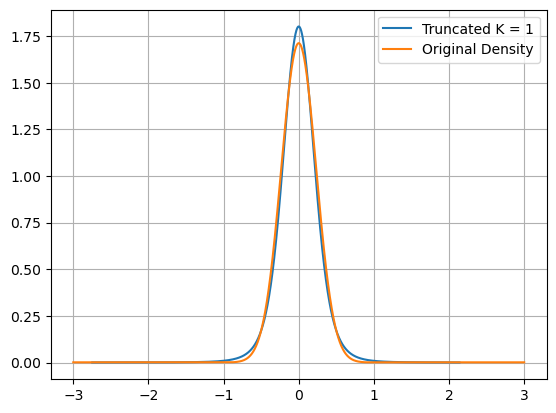

In [11]:
# Transform to density space. Compare truncated representation against real density
truncated_representations = inverse_log_qd_transform(
    truncated_representations_transforms,
)
truncated_representations[0].compare(
    new_pdfs[0].warp_range(-trunc, trunc),
    label_self = "Truncated K = 1",
    label_other = "Original Density"
)

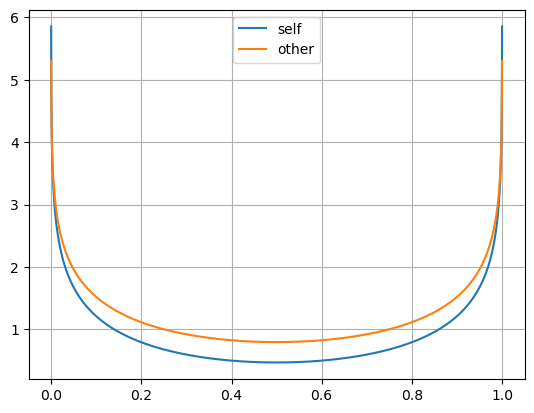

In [12]:
# Look at modes of variance of transformed functions
variation_modes_transforms = [
    mode_of_variation(mean_log_qdfs, eigval, eigfunc, alpha=5e-3)
    for eigval, eigfunc in zip(eigenvalues_log_qdfs, eigenfunctions_log_qdfs)
]
variation_modes_transforms[0].compare(variation_modes_transforms[1])

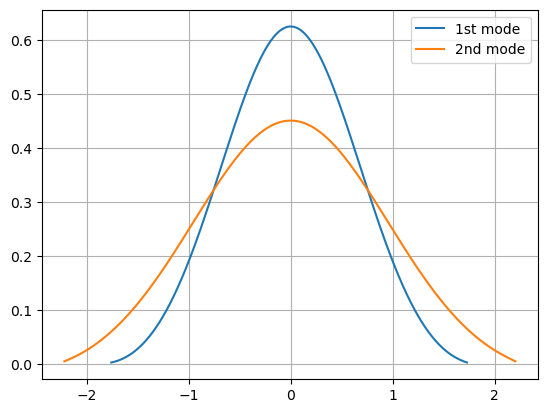

In [13]:
# Translate modes of variation to density space, compare first two modes
variation_modes = inverse_log_qd_transform(variation_modes_transforms)
variation_modes[0].compare(
    variation_modes[1], label_self = "1st mode", label_other = "2nd mode"
)

In [14]:
# Compute Fréchet mean
f_mean = frechet_mean(new_pdfs)

In [15]:
# Compute Fréchet variance
total_variance = total_frechet_variance(f_mean, new_pdfs)

In [16]:
# Try function that finds optimal trunc representation
optimal_k, fraction_explained, truncated_representations = k_optimal(
    0.5,
    total_variance,
    new_pdfs,
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
)
optimal_k, fraction_explained

(1, 0.9900090309807394)

# Simulation

In [17]:
# Number of simulations
m = 3
sample_sizes = [50, 100, 200]
# Initialize arrays to store Fréchet and cross sectional means
stored_f_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means = np.empty((m, len(sample_sizes)), dtype="object")

In [18]:
print("Simulating...", end="\r")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing Fréchet means below!
        # Set parameters
        grid_size = 10000
        trunc = 3
        seed_num = int(str(i) + str(n))
        mus, sigmas = gen_params_scenario_one(n, seed=seed_num)
        # Sort sigmas, because when summing Distribution instances something goes wrong otherwise
        sigmas.sort()

        # Generate pdfs within truncation points
        pdfs = make_truncnorm_pdf(-trunc, trunc, mus, sigmas, grid_size=grid_size)
        # Make Distribution class objects
        my_pdfs = make_distribution_objects(pdfs)
        my_cdfs = [pdf.integrate() for pdf in my_pdfs]
        my_qfs = [cdf.invert() for cdf in my_cdfs]
        my_qdfs = [qf.differentiate() for qf in my_qfs]
        # For numerical correction: shorten the range for smaller sigmas to get rid of
        # numerical artifacts when computing integrals, derivatives and means later
        new_ranges = get_optimal_range(my_pdfs)
        # Generate pdfs again, this time within individual ranges
        pdfs2 = [
            make_truncnorm_pdf(
                new_ranges[i][0],
                new_ranges[i][1],
                mus[i],
                sigmas[i],
                grid_size=grid_size,
            )[0]
            for i in range(n)
        ]

        # Generate all the distribution objects
        new_pdfs = make_distribution_objects(pdfs2)
        new_cdfs = [pdf.integrate() for pdf in new_pdfs]
        new_qfs = [cdf.invert() for cdf in new_cdfs]
        new_qdfs = [qf.differentiate() for qf in new_qfs]

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdfs)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs)

        # Compute Fréchet mean
        stored_f_means[i, j] = frechet_mean(new_pdfs)
        stored_cs_means[i, j] = mean_func(new_pdfs)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(f_mean, new_pdfs)
        # # Try function that finds optimal trunc representation
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            0.5,
            total_variance,
            new_pdfs,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )
    perc = int(100 * (i + 1) / m)
    print(f"Simulating...{perc}%", end="\r")

C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.00045321862720459904
 In position: 49
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.9685233384914014e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 3.824126197993216e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 4.3576303813575024e-05
 In position: 0
 Performing normal

C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.0004476686040486566
 In position: 49
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.0263221235984332e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 2.334463113951024e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 4.980945381438673e-05
 In position: 0
 Performing normaliz

C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 0.00045467643830376936
 In position: 49
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.543523735336727e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.7168330357808514e-05
 In position: 0
 Performing normalization...
  warnings.warn(
C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.7601409199929918e-05
 In position: 0
 Performing normal

In [19]:
# Calculate true center of distribution for plotting against estimates
std_normal = make_truncnorm_pdf(-trunc, trunc, 0, 1, grid_size=grid_size)[0]

C:\Coding\frechet_fda\src\frechet_fda\data_generation_tools.py:115: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.4254831923077305e-05
 In position: 0
 Performing normalization...
  warnings.warn(


In [20]:
# Calculate Fréchet means of Fréchet means over all simulations
mean_of_f_means50 = frechet_mean(stored_f_means[:, 0])
mean_of_f_means100 = frechet_mean(stored_f_means[:, 1])
mean_of_f_means200 = frechet_mean(stored_f_means[:, 2])
mean_of_cs_means50 = frechet_mean(stored_cs_means[:, 0])
mean_of_cs_means100 = frechet_mean(stored_cs_means[:, 1])
mean_of_cs_means200 = frechet_mean(stored_cs_means[:, 2])

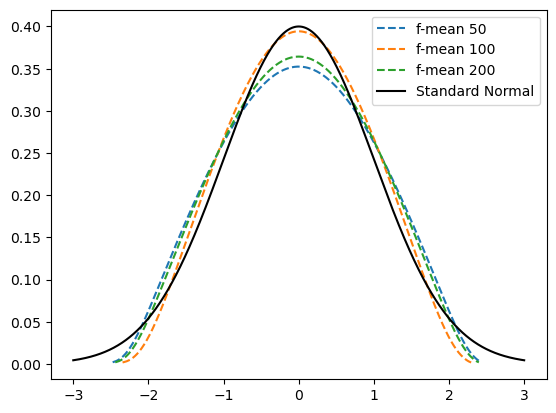

In [21]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means50.x, mean_of_f_means50.y, label="f-mean 50", linestyle="--")
ax.plot(mean_of_f_means100.x, mean_of_f_means100.y, label="f-mean 100", linestyle="--")
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="f-mean 200", linestyle="--")
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.show()

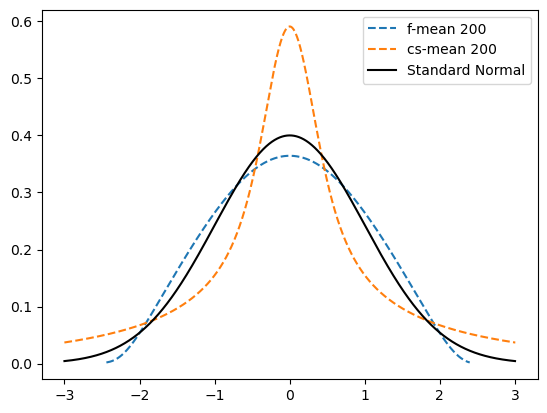

In [22]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="f-mean 200", linestyle="--")
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="cs-mean 200",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.show()

## Implement density estimation step

In [23]:
from frechet_fda.data_generation_tools import (
    gen_truncnorm_pdf_points,
    make_estimated_truncnorm_pdf
)

In [24]:
grid_size = 10000
trunc = 3
mus, sigmas = gen_params_scenario_one(n, seed=123456)
# Sort sigmas, because when summing Distribution instances something goes wrong otherwise
sigmas.sort()

In [25]:
sample_points = gen_truncnorm_pdf_points(-trunc, trunc, mus, sigmas, 100)

In [26]:
pdf_hats = make_estimated_truncnorm_pdf(sample_points, -trunc, trunc)

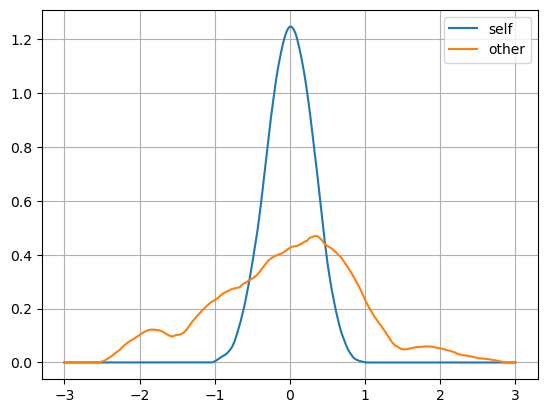

In [27]:
pdf_hats[0].compare(pdf_hats[100])